# Integration and calibration benchmarks

This benchmark relies on prod3b files containing true photon electron images

If you don't have such a file, you may jump to the [last part](#load_datasets) and load the hdf5 file with some pre-analysed data.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from copy import deepcopy, copy

from ctapipe.utils import get_dataset_path
from ctapipe.io import event_source
from ctapipe.calib import CameraCalibrator
from ctapipe.visualization import CameraDisplay
from ctapipe.io import HDF5TableWriter
from ctapipe.io.containers import Container, Field

In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [70]:
def get_noise(calibrated_event, tel_id):
    """
    This function select pixels that contain only noise based on the true pe image
    and return the calibrated image of these pixels
    """
    pe_image = calibrated_event.mc.tel[tel_id].photo_electron_image
    signal_pixels = pe_image > 0
    noise = copy(calibrated_event.dl1.tel[tel_id].image[0])
    noise[signal_pixels] = 0
    return noise[~signal_pixels]

def get_signal(calibrated_event, tel_id):
    """
    This function select pixels that contain signal based on the true pe image
    and return the calibrated image of these pixels
    """
    pe_image = calibrated_event.mc.tel[tel_id].photo_electron_image
    signal_pixels = pe_image > 0
    signal = copy(calibrated_event.dl1.tel[tel_id].image[0])
    signal[~signal_pixels] = 0
    return signal[signal_pixels]

def get_noise_distr(calibrated_event):
    """
    This function returns the distribution of noisy calibrated pixels for all triggered telescopes
    """
    noise = []
    for tel_id in event.r0.tels_with_data:
        noise.append(get_noise(calibrated_event, tel_id))
        
    return np.concatenate(noise)

def get_signal_distr(calibrated_event):
    """
    This function returns the distribution of signal calibrated pixels for all triggered telescopes
    """
    signal = []
    for tel_id in event.r0.tels_with_data:
        signal.append(get_signal(calibrated_event, tel_id))
        
    return np.concatenate(signal)

In [65]:
# infile = get_dataset_path('gamma_test_large.simtel.gz')
infile = '/Users/thomasvuillaume/Work/CTA/Data/Simtel/gamma_40deg_0deg_run102___cta-prod3-lapalma3-2147m-LaPalma_cone10.simtel.gz'
source = event_source(infile, max_events=1000)

In [66]:
events = [deepcopy(event) for event in source]

## Testing and visulisation

In [7]:
cal = CameraCalibrator(r1_product='HESSIOR1Calibrator',
                       extractor_product='NeighbourPeakIntegrator')

event = events[2]
cal.calibrate(event);

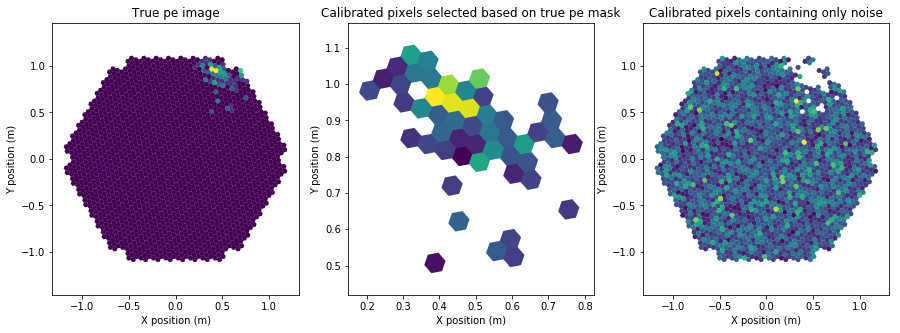

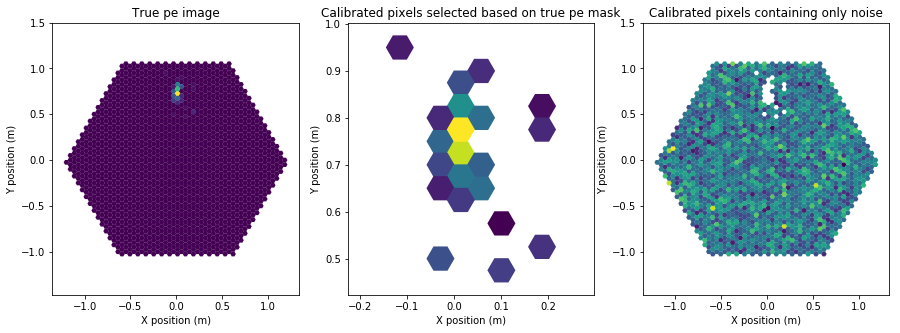

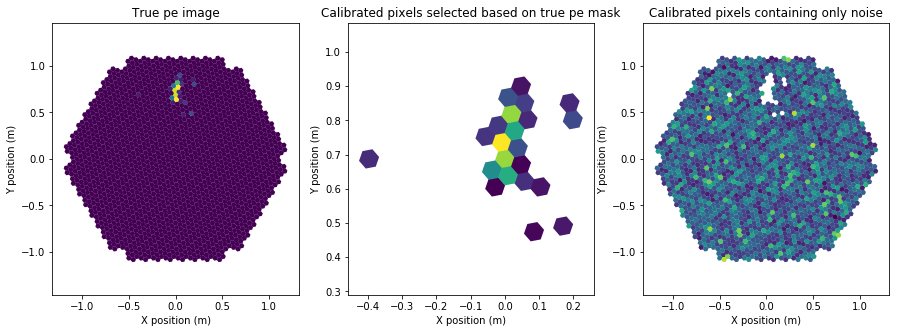

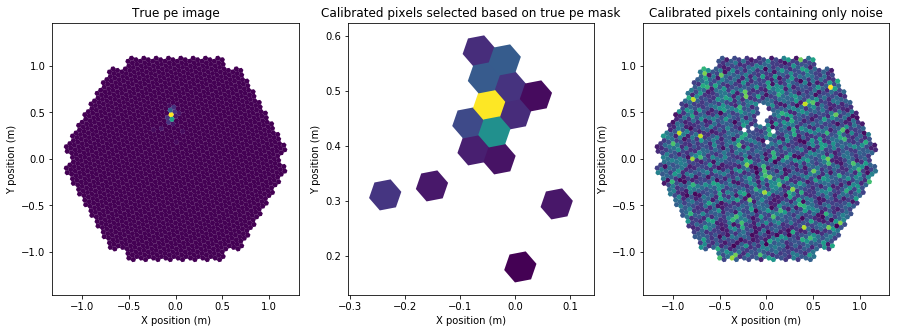

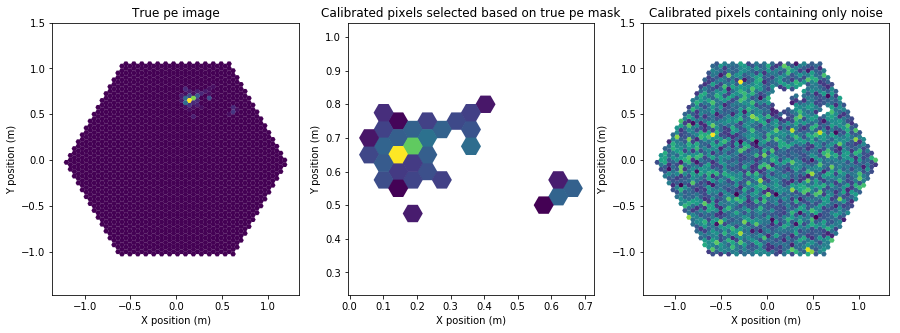

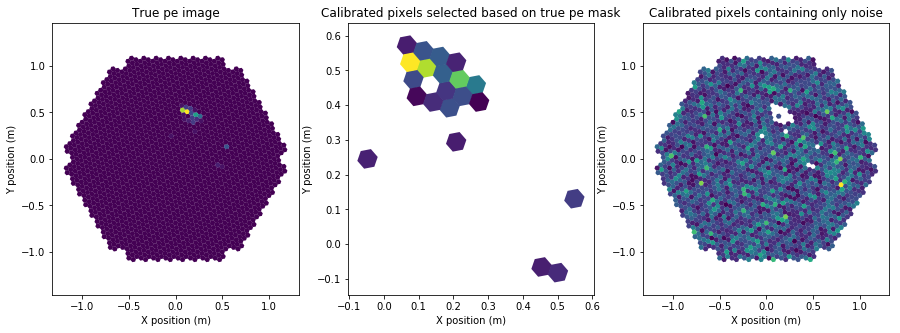

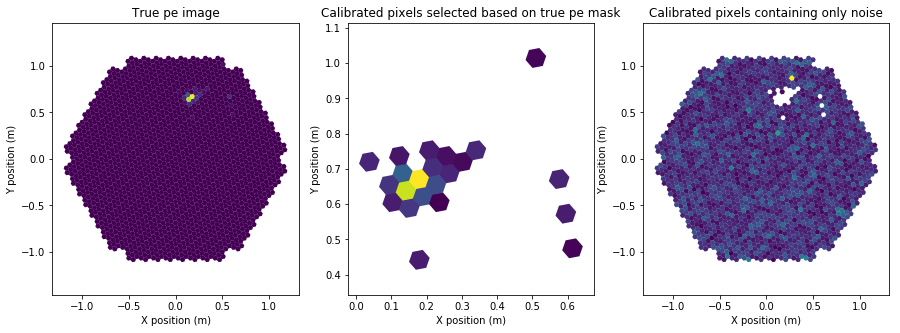

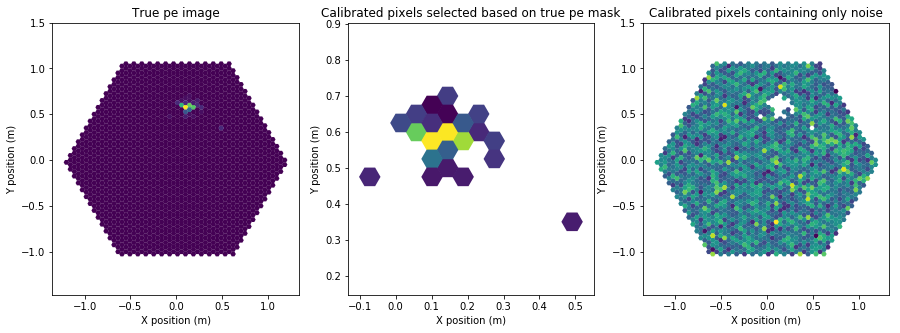

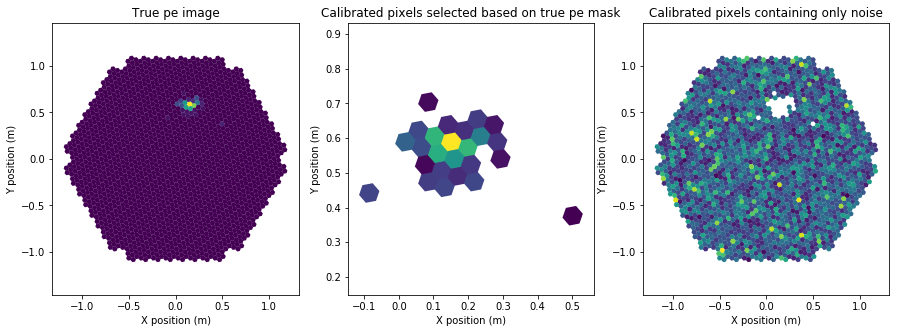

In [8]:
for tel_id in event.r0.tels_with_data:
    fig, axes = plt.subplots(1,3, figsize=(15,5))
    geom = event.inst.subarray.tel[tel_id].camera
    pe_image = event.mc.tel[tel_id].photo_electron_image
    signal = get_signal(event, tel_id)
    noise = get_noise(event, tel_id)
    CameraDisplay(geom, pe_image, ax=axes[0])
    axes[0].set_title("True pe image")
    CameraDisplay(geom[pe_image>0], signal, ax=axes[1])
    axes[1].set_title("Calibrated pixels selected based on true pe mask")
    CameraDisplay(geom[pe_image<=0], noise, ax=axes[2])
    axes[2].set_title("Calibrated pixels containing only noise")
    plt.show()

## Testing different integrations

In [73]:
noise_distributions = {}
signal_distributions = {}

In [68]:
integrators = {0: 'NeighbourPeakIntegrator',
               1: 'LocalPeakIntegrator',
               2: 'FullIntegrator'
              }

The following plot shows the distributions of calibrated noise and calibrated signals for different integration algorithms.   
The calibration algorithm is always the `HESSIOR1Calibrator`.

In [74]:
for ii, integrator in integrators.items():
    cal = CameraCalibrator(r1_product='HESSIOR1Calibrator',
                       extractor_product=integrator)

    [cal.calibrate(event) for event in events]
    
    noise_dist = np.empty(0)
    signal_dist = np.empty(0)
    for event in events:
        noise_dist = np.concatenate([noise_dist, get_noise_distr(event)])
        signal_dist = np.concatenate([signal_dist, get_signal_distr(event)])
    
    noise_distributions[integrator] = noise_dist
    signal_distributions[integrator] = signal_dist
    
axes[0].set_title("Noise distribution")
axes[1].set_title("Signal distribution")
axes[0].legend();
axes[1].legend();

NeighbourPeakIntegrator noise mean: 0.0115
NeighbourPeakIntegrator signal mean: 9.8684
LocalPeakIntegrator noise mean: 2.7395
LocalPeakIntegrator signal mean: 11.4504
FullIntegrator noise mean: 0.0420
FullIntegrator signal mean: 11.2369


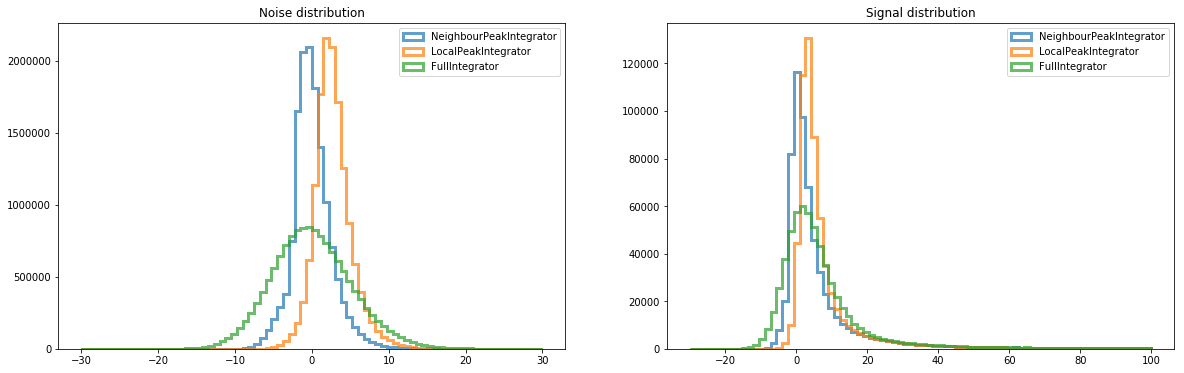

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

for ii, integrator in integrators.items():
    noise_dist = noise_distributions[integrator]
    signal_dist = signal_distributions[integrator]
    
    axes[0].hist(noise_dist, label=integrator, bins=80, alpha=0.7, histtype='step', linewidth=3, range=(-30,30))
    axes[1].hist(signal_dist, label=integrator, bins=80, alpha=0.7, histtype='step', range = (-30, 100), linewidth=3)
    print("{} noise mean: {:.4f}".format(integrator, noise_dist.mean()))
    print("{} signal mean: {:.4f}".format(integrator, signal_dist.mean()))
    
axes[0].set_title("Noise distribution")
axes[1].set_title("Signal distribution")
axes[0].legend();
axes[1].legend();

## Testing different calibration

In [77]:
calibrators = {0: 'NullR1Calibrator',
               1: 'HESSIOR1Calibrator',
              }

The following plot show the distributions of calibrated noise and signal for different calibration algorithms.   
The integration algorithm is always the `NeighbourPeakIntegrator`.

In [78]:
for ii, calibrator in calibrators.items():
    
    cal = CameraCalibrator(r1_product=calibrator,
                       extractor_product='NeighbourPeakIntegrator')

    [cal.calibrate(event) for event in events]
    
    noise_dist = np.empty(0)
    signal_dist = np.empty(0)
    for event in events:
        noise_dist = np.concatenate([noise_dist, get_noise_distr(event)])
        signal_dist = np.concatenate([signal_dist, get_signal_distr(event)])
         
    noise_distributions[calibrator] = noise_dist
    signal_distributions[calibrator] = signal_dist
    

NullR1Calibrator noise mean: 1047.6958
NullR1Calibrator signal mean: 1933.0098
HESSIOR1Calibrator noise mean: 0.0115
HESSIOR1Calibrator signal mean: 9.8684


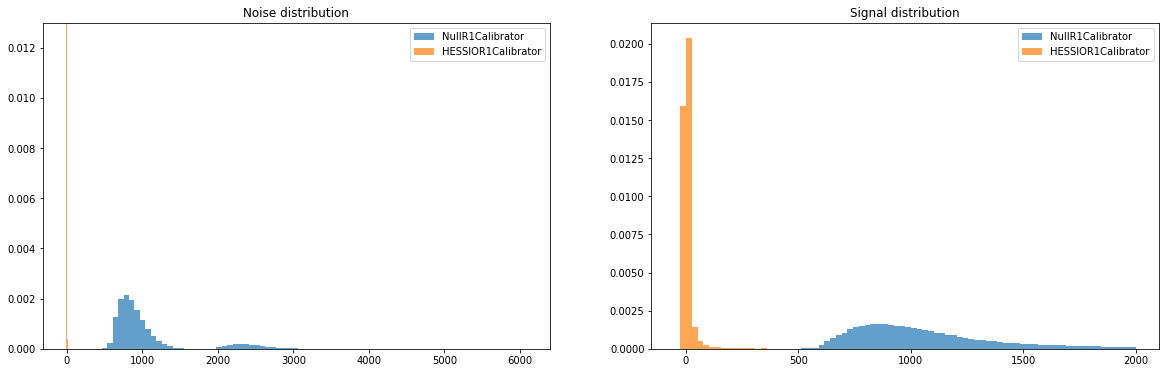

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

for ii, calibrator in calibrators.items():
    noise_dist = noise_distributions[calibrator]
    signal_dist = signal_distributions[calibrator]
    
    axes[0].hist(noise_dist, label=calibrator, bins=80, alpha=0.7, density=True)
    axes[1].hist(signal_dist, label=calibrator, bins=80, alpha=0.7, range=(-50, 2000), density=True)
    axes[1].set_xlim()
    print("{} noise mean: {:.4f}".format(calibrator, noise_dist.mean()))
    print("{} signal mean: {:.4f}".format(calibrator, signal_dist.mean()))
    
axes[0].set_ylim(0, 0.013)
axes[0].set_title("Noise distribution")
axes[1].set_title("Signal distribution")
axes[0].legend();
axes[1].legend();

# Correlation of signal with true pe signal

In [93]:
def difference_cal_true(calibrated_event, tel_id):
    """
    Return the difference between the calibrated signal and the true pe signal
    """
    calibrated_signal = get_signal(event, tel_id)
    true_signal = event.mc.tel[tel_id].photo_electron_image
    
    return np.sum(calibrated_signal - true_signal[true_signal>0])

In [94]:
def plot_binned_mean(x, y, ax=None, errorbar=False, bins=20, **kwargs):
    """
    Plot binned statistics
    """
    
    from scipy import stats
    
    ax = plt.gca() if ax is None else ax
    
    bin_means, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='mean', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    
    bin_with_data = np.unique(binnumber) - 1
    bin_r68 = np.array([np.percentile(np.abs(y[binnumber==i]-bin_means[i-1]), 68) \
                        for i in set(binnumber)])

    ax.hlines(bin_means, bin_edges[:-1], bin_edges[1:], **kwargs)
    if 'label' in kwargs: kwargs.pop('label')
    ax.vlines(bin_centers[bin_with_data], 
              bin_means[bin_with_data] - bin_r68, 
              bin_means[bin_with_data] + bin_r68,
              **kwargs
             )
    
    return ax

## The calibrated data are saved in an hdf5 file

In [32]:
class IntContainer(Container):
    true_pe = Field(float, 'true_pe')
    calibrated_pe = Field(float, 'calibrated_pe')
    integrator = Field(int, 'integrator')


In [33]:
int_container = IntContainer()

with HDF5TableWriter('container.h5', group_name='data') as h5_table:

    for ii, integrator in integrators.items():
        print(integrator)

        cal = CameraCalibrator(r1_product='HESSIOR1Calibrator',
                           extractor_product=integrator)

        [cal.calibrate(event) for event in events] 

        for event in events:
            for tel_id in event.r0.tels_with_data:
                camera = event.inst.subarray.tel[tel_id].camera
                diff_sum += difference_cal_true(event, tel_id)
                calibrated_signal = get_signal(event, tel_id)
                true_signal = event.mc.tel[tel_id].photo_electron_image
                
                int_container.true_pe = event.mc.tel[tel_id].photo_electron_image.sum()
                int_container.calibrated_pe = calibrated_signal.sum()
                int_container.integrator = ii
                
                h5_table.write(camera.cam_id, [event.r0, event.mc, int_container])


NeighbourPeakIntegrator
LocalPeakIntegrator
FullIntegrator


<a id='load_datasets'></a>
### Load the datasets

In [3]:
lst = pd.read_hdf('container.h5', key='data/LSTCam')
nectar = pd.read_hdf('container.h5', key='data/NectarCam')
flash = pd.read_hdf('container.h5', key='data/FlashCam')

In [16]:
print("LST dataset contains data from {} images".format(len(lst)))
print("Nectar dataset contains data from {} images".format(len(nectar)))
print("Flash dataset contains data from {} images".format(len(flash)))

lst.head()

LST dataset contains data from 2799 images
Nectar dataset contains data from 10920 images
Flash dataset contains data from 10647 images


,alt,az,calibrated_pe,core_x,core_y,energy,event_id,h_first_int,integrator,obs_id,shower_primary_id,true_pe,x_max
0,48.754911,0.803539,59.185786,-159.620728,270.631348,0.014971,14410,24470.238281,0,102,0,65,138.00
1,48.754911,0.803539,54.943470,-159.620728,270.631348,0.014971,14410,24470.238281,0,102,0,53,138.00
2,49.862157,3.403465,89.449050,-426.062897,103.151390,0.131580,17300,25982.017578,0,102,0,111,196.25
3,49.805808,359.133314,45.682059,49.245983,-196.828247,0.032342,24507,33559.382812,0,102,0,57,144.00
4,49.805808,359.133314,52.670787,49.245983,-196.828247,0.032342,24507,33559.382812,0,102,0,53,144.00


LSTCam


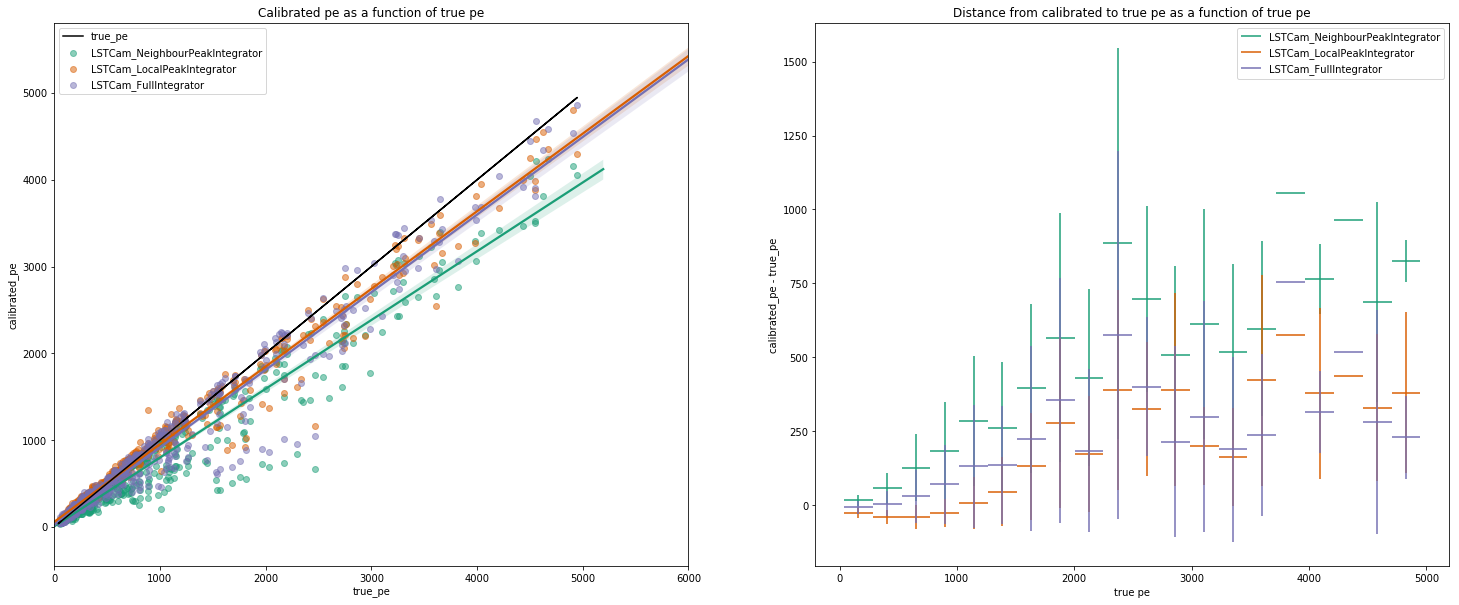

NectarCam


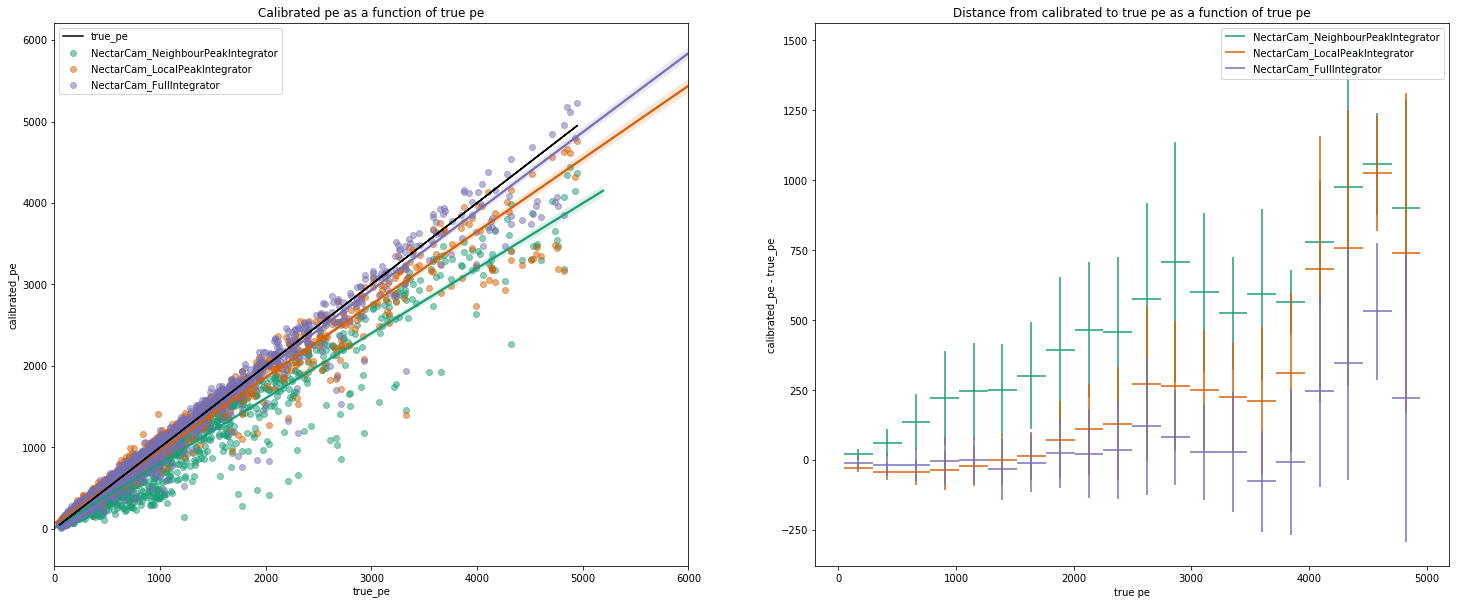

FlashCam


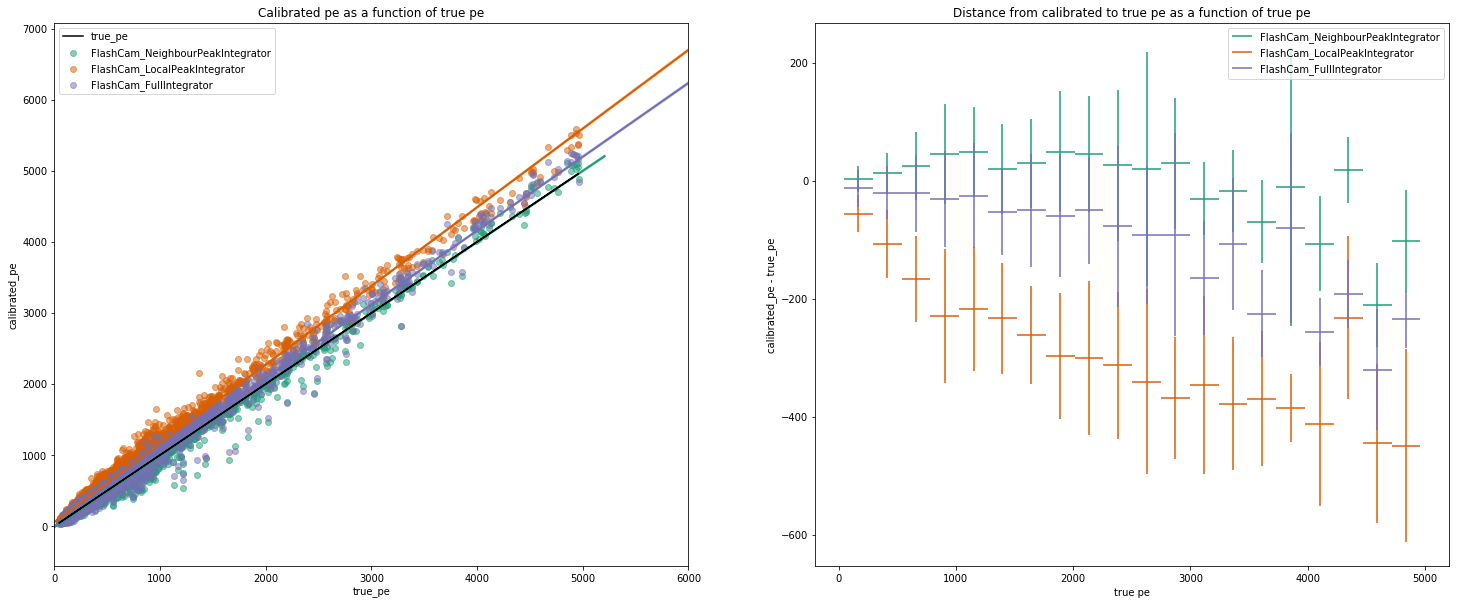

In [95]:
for cam_id in ['LSTCam', 'NectarCam', 'FlashCam']:
    fig, axes = plt.subplots(1, 2, figsize=(25,10))
    df = pd.read_hdf('container.h5', key='data/'+cam_id)
    print(cam_id)
    for ii in range(3):
        data = df[(df.true_pe < 5000) & (df.integrator==ii)]

        reg = sns.regplot(data.true_pe, 
                    data.calibrated_pe, 
                    label=cam_id+'_'+integrators[ii],
                    scatter_kws={'alpha':0.5},
                    ax=axes[0],
                    color=plt.cm.Dark2(ii),
               )
        reg.axes.set_xlim(0, 6000)

        plot_binned_mean(data.true_pe, data.true_pe - data.calibrated_pe, 
                         color=plt.cm.Dark2(ii),
                         label=cam_id+'_'+integrators[ii],
                         ax=axes[1],
                        )
    
    
    axes[0].plot(data.true_pe, data.true_pe, color='black')
    
    axes[1].set_xlabel("true_pe")
    axes[1].set_ylabel("calibrated_pe - true_pe")
    axes[0].set_title("Calibrated pe as a function of true pe")
    axes[1].set_title("Distance from calibrated to true pe as a function of true pe")
    axes[0].legend()
    axes[1].legend()
    plt.show()

From these plots, the `FlashCam` calibration seems better overall (signal closer to true pe with less dispersion).   
It seems difficult to conclude between different calibrators from these plots.